## Установка нужных библиотек

In [208]:
pip install optuna lightgbm xgboost

Note: you may need to restart the kernel to use updated packages.


## EDA: удаление дубликатов, объединение таблиц, чистка данных и т.п.

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import numpy as np

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings('ignore')

In [210]:
# Загрузим данные
credit_info = pd.read_excel('Credit_Info.xlsx')
customer_info = pd.read_excel('Customer_Info.xlsx')
history_info = pd.read_excel('History_Info.xlsx')

# <YOUR_CODE_HERE>
history_info['Loan Type'].unique()

array(['ConsumerLoan', 'MortgageLoan', 'BusinessLoan'], dtype=object)

In [211]:
history_info['Overdues']

0        1
1        0
2        0
3        0
4        0
        ..
2028     0
2029     0
2030     0
2031    33
2032    36
Name: Overdues, Length: 2033, dtype: int64

In [212]:
# Прежде всего нужно объединить три таблицы, каждая содержит круаицу нужную для качественных предсказаний

In [213]:
history_agg = (history_info.groupby("Customer ID").agg(
        hist_notes   = ("History Note ID", "count"),
        overdues_sum = ("Overdues", "sum"),
        overdues_max = ("Overdues", "max"),
        overdues_mean= ("Overdues", "mean"),
        n_loan_types = ("Loan Type", "nunique"),
        last_end     = ("End Date", "max")).reset_index())
# Loan types:history_agg.head()

In [214]:
history_agg.head()

,Customer ID,hist_notes,overdues_sum,overdues_max,overdues_mean,n_loan_types,last_end
0,1,3,54,49,18.000000,2,2021-01-30
1,16,5,0,0,0.000000,3,2021-10-03
2,17,6,0,0,0.000000,2,2023-08-12
3,18,2,87,83,43.500000,1,2022-11-03
4,19,3,4,4,1.333333,3,2022-08-26


In [215]:
customer_info.columns
df1 = pd.merge(credit_info,customer_info, on='Customer ID', how='left')
df = pd.merge(df1, history_agg, on='Customer ID', how='left')
df

,Credit ID,Customer ID,Loan Created Date,Type Credit,Sex,Birthday,hist_notes,overdues_sum,overdues_max,overdues_mean,n_loan_types,last_end
0,857000,483,2020-09-05,Normal,Woman,1959-06-15,1,0,0,0.000000,1,2021-07-02
1,695553,843,2021-05-20,Normal,Man,1960-09-25,3,38,32,12.666667,2,2022-03-16
2,992484,1801,2021-07-02,Normal,Woman,1982-12-24,2,32,32,16.000000,2,2022-04-28
3,964325,296,2021-09-25,Normal,Man,1982-08-17,1,2,2,2.000000,1,2022-07-22
4,602834,694,2021-04-21,Normal,Woman,1952-12-07,5,4,4,0.800000,3,2022-02-15
...,...,...,...,...,...,...,...,...,...,...,...,...
786,368316,857,2021-10-15,Normal,Man,1993-01-22,7,80,79,11.428571,3,2022-08-11
787,797427,371,2022-03-06,Problem,Woman,1949-04-12,3,66,40,22.000000,2,2022-12-31
788,490044,1207,2020-03-30,Problem,Man,1955-08-29,1,67,67,67.000000,1,2021-01-24
789,698771,1357,2022-10-29,Normal,Woman,1991-06-01,2,1,1,0.500000,2,2023-08-25


In [216]:
df['n_loan_types'].unique()

array([1, 2, 3])

In [217]:
# Смотрим нет ли дубликатов после объединения
double = df[df.duplicated(subset=["Customer ID", "Credit ID"])]
double

,Credit ID,Customer ID,Loan Created Date,Type Credit,Sex,Birthday,hist_notes,overdues_sum,overdues_max,overdues_mean,n_loan_types,last_end


In [218]:
df.isnull().sum() # Нужно делать что-то с 'Birthdays'

Credit ID             0
Customer ID           0
Loan Created Date     0
Type Credit           0
Sex                   0
Birthday             36
hist_notes            0
overdues_sum          0
overdues_max          0
overdues_mean         0
n_loan_types          0
last_end              0
dtype: int64

In [219]:
# Сохранила колонки, чтобы не терять данные. Подставила медиану вместо Nan.
brth_median = df['Birthday'].median()
df['Birthday']=df['Birthday'].fillna(brth_median)
#! Можно было бы вместе с Null поправить выбросы (Например: более 100 лет или меньше 5-и)


In [220]:
# Предобработка datetime формата, так как я не могу просто так их скормить модели, а вывести полезные признаки можно.

In [221]:
today = pd.Timestamp.today()
df["Birthday"] = pd.to_datetime(df["Birthday"], errors="coerce")
df["loan_date"] = pd.to_datetime(df["Loan Created Date"], dayfirst=True)
df["loan_end"] = pd.to_datetime(df["last_end"], errors="coerce", dayfirst=True)
df["Age"] = (df["loan_date"] - df["Birthday"]).dt.days // 365 #! дату рождения следовало вычитать из даты заявки или другой исторической даты имеющей какое-то значение на момент заявки (today сейчас сильно отличается от today на момент формирования заявки)

df['loan_days']= (df['loan_end']-df['loan_date']).dt.days

df["loan_year"] = df["loan_date"].dt.year
df["loan_months"] = df["loan_date"].dt.month

df["gender"] = df["Sex"].map({"Woman": 1, "Man": 0}).astype('float64')
df['TARGET'] = df['Type Credit'].map({'Problem':1, 'Normal':0}).astype('float64')

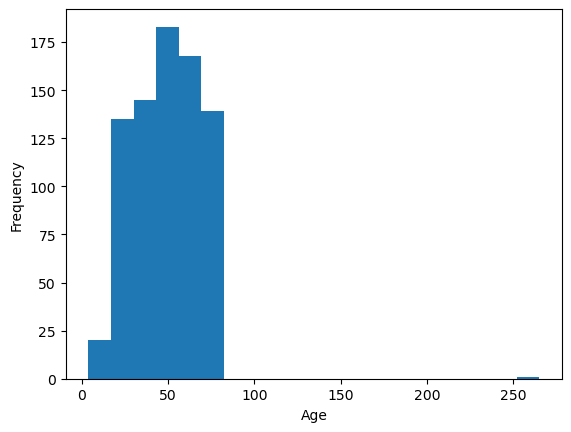

In [222]:
df['Age'].plot(kind='hist', bins=20)
plt.xlabel('Age')
#plt.xlim(50,150)
plt.show()

In [223]:
count_outlier = df[df['Age']<5].shape[0]
count_outliers = df[df['Age']>100].shape[0]
print(f'Extremely young customers: {count_outlier}, impossibly old customers: {count_outliers}')

Extremely young customers: 2, impossibly old customers: 1


In [224]:
df['Age'].astype(int)

0      61
1      60
2      38
3      39
4      68
       ..
786    28
787    72
788    64
789    31
790    67
Name: Age, Length: 791, dtype: int64

In [225]:
# df w/o Age outliers
df = df[(df['Age']>=5)  & (df['Age'] <100)]
df

,Credit ID,Customer ID,Loan Created Date,Type Credit,Sex,Birthday,hist_notes,overdues_sum,overdues_max,overdues_mean,n_loan_types,last_end,loan_date,loan_end,Age,loan_days,loan_year,loan_months,gender,TARGET
0,857000,483,2020-09-05,Normal,Woman,1959-06-15,1,0,0,0.000000,1,2021-07-02,2020-09-05,2021-07-02,61,300,2020,9,1.0,0.0
1,695553,843,2021-05-20,Normal,Man,1960-09-25,3,38,32,12.666667,2,2022-03-16,2021-05-20,2022-03-16,60,300,2021,5,0.0,0.0
2,992484,1801,2021-07-02,Normal,Woman,1982-12-24,2,32,32,16.000000,2,2022-04-28,2021-07-02,2022-04-28,38,300,2021,7,1.0,0.0
3,964325,296,2021-09-25,Normal,Man,1982-08-17,1,2,2,2.000000,1,2022-07-22,2021-09-25,2022-07-22,39,300,2021,9,0.0,0.0
4,602834,694,2021-04-21,Normal,Woman,1952-12-07,5,4,4,0.800000,3,2022-02-15,2021-04-21,2022-02-15,68,300,2021,4,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,368316,857,2021-10-15,Normal,Man,1993-01-22,7,80,79,11.428571,3,2022-08-11,2021-10-15,2022-08-11,28,300,2021,10,0.0,0.0
787,797427,371,2022-03-06,Problem,Woman,1949-04-12,3,66,40,22.000000,2,2022-12-31,2022-03-06,2022-12-31,72,300,2022,3,1.0,1.0
788,490044,1207,2020-03-30,Problem,Man,1955-08-29,1,67,67,67.000000,1,2021-01-24,2020-03-30,2021-01-24,64,300,2020,3,0.0,1.0
789,698771,1357,2022-10-29,Normal,Woman,1991-06-01,2,1,1,0.500000,2,2023-08-25,2022-10-29,2023-08-25,31,300,2022,10,1.0,0.0


In [226]:
count300 = (df['loan_days']==300).shape[0]
count300

788

In [227]:
numerical_cols = ['hist_notes', 'overdues_sum', 'overdues_max', 'overdues_mean', 'n_loan_types	', 'Age', 'loan_year', 'loan_days', 'loan_months', 'TARGET', 'gender']

In [228]:
numerical_df = df.select_dtypes(include="number").copy()
numerical_df

,Credit ID,Customer ID,hist_notes,overdues_sum,overdues_max,overdues_mean,n_loan_types,Age,loan_days,loan_year,loan_months,gender,TARGET
0,857000,483,1,0,0,0.000000,1,61,300,2020,9,1.0,0.0
1,695553,843,3,38,32,12.666667,2,60,300,2021,5,0.0,0.0
2,992484,1801,2,32,32,16.000000,2,38,300,2021,7,1.0,0.0
3,964325,296,1,2,2,2.000000,1,39,300,2021,9,0.0,0.0
4,602834,694,5,4,4,0.800000,3,68,300,2021,4,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,368316,857,7,80,79,11.428571,3,28,300,2021,10,0.0,0.0
787,797427,371,3,66,40,22.000000,2,72,300,2022,3,1.0,1.0
788,490044,1207,1,67,67,67.000000,1,64,300,2020,3,0.0,1.0
789,698771,1357,2,1,1,0.500000,2,31,300,2022,10,1.0,0.0


<Axes: ylabel='count'>

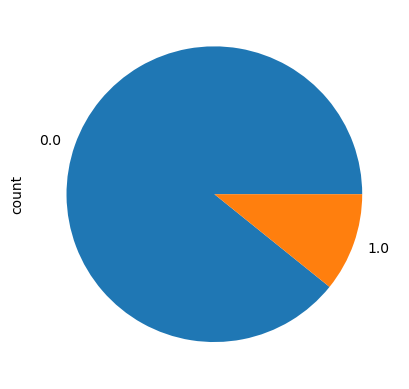

In [229]:
df['TARGET'].value_counts().plot(kind='pie')
# Imbalanced dataset

## Выявление наиболее влиятельных features через correlation matrix и Sequential Feature Selector

<Axes: >

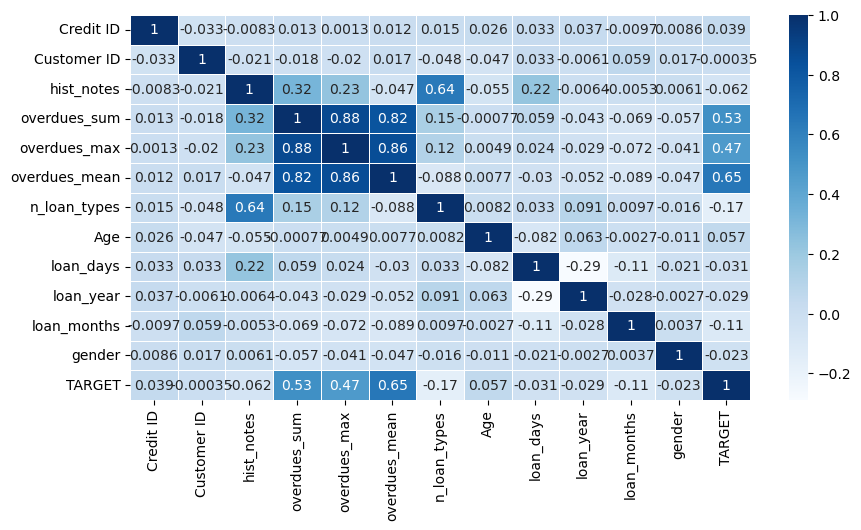

In [230]:
#! Я бы не стал рассамтривать ID кредита и клиента как фичи. Эти поля определяются особенностями потроения базы данных, а не тем, какую информацию несут кредит и клиент.
# Корреляционная матрица, чтобы выявить признаки
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5)

Target коррелирует значительнее всего с overdues колонками

In [231]:
#SFS для выявления наиболее оптимальных features
SFS = SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=8, direction='backward')

In [232]:
X1=numerical_df.drop(['Credit ID','Customer ID','TARGET'],  axis=1)
y1= numerical_df['TARGET']

In [233]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=101)

In [234]:
X_train1.isnull().sum()

hist_notes       0
overdues_sum     0
overdues_max     0
overdues_mean    0
n_loan_types     0
Age              0
loan_days        0
loan_year        0
loan_months      0
gender           0
dtype: int64

In [235]:
SFS.fit(X_train1, y_train1)

SequentialFeatureSelector(direction='backward', estimator=LogisticRegression(),
                          n_features_to_select=8)

In [236]:
sfs_features = X_train1.columns[SFS.get_support()].tolist()

In [237]:
sfs_features

['hist_notes',
 'overdues_max',
 'overdues_mean',
 'n_loan_types',
 'Age',
 'loan_days',
 'loan_year',
 'loan_months']

In [238]:
# Для сравнения features из коррелляции

In [239]:
numerical_df.corr(numeric_only=True)['TARGET'].sort_values(ascending=False)

TARGET           1.000000
overdues_mean    0.646434
overdues_sum     0.526695
overdues_max     0.467245
Age              0.057163
Credit ID        0.038579
Customer ID     -0.000352
gender          -0.022982
loan_year       -0.029479
loan_days       -0.031292
hist_notes      -0.061536
loan_months     -0.105406
n_loan_types    -0.167692
Name: TARGET, dtype: float64

## Hyperparameters tuning and balancing target using SMOTE

In [256]:
selected_features = ['overdues_max','overdues_mean', 'overdues_sum',
 'n_loan_types', 'Age', 'gender', 'loan_year', 'loan_months']

In [257]:
X = numerical_df[selected_features]
y = numerical_df['TARGET']

In [258]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=101)

In [259]:
# Dealing with imbalance

In [260]:
smote = SMOTE(random_state=101)

In [261]:
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [262]:
# Objective functions for HP tuning by OPTUNA

In [263]:
def objective(trial):
    params = {
       "n_estimators": trial.suggest_int("lgb_n_estimators", 500, 3000, step=250),
        "learning_rate": trial.suggest_float("lgb_lr", 0.005, 0.2, log=True),
        "num_leaves": trial.suggest_int("lgb_num_leaves", 31, 255),
        "max_depth":trial.suggest_int("lgb_max_depth", -1, 24),
        "min_child_samples": trial.suggest_int("lgb_min_child_samples", 5, 200),
        "subsample": trial.suggest_float("lgb_subsample", 0.6, 1.0),
        "objective": "binary",
        "n_jobs": -1,
        "objective": "binary",
        "verbose": -1,}
    lgbc = LGBMClassifier(**params)
    lgbc.fit(X_train_bal, y_train_bal)
    val_preds = lgbc.predict_proba(X_test)[:, 1]
    auc_sc = roc_auc_score(y_test, val_preds)
    return auc_sc

Training Optuna

In [264]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best accuracy:", study.best_trial.value)

[I 2025-08-23 14:10:26,005] A new study created in memory with name: no-name-4d6c29a7-6508-4991-9662-35cad9147c07
[I 2025-08-23 14:10:39,603] Trial 0 finished with value: 0.941305140357273 and parameters: {'lgb_n_estimators': 2000, 'lgb_lr': 0.006530019895714994, 'lgb_num_leaves': 224, 'lgb_max_depth': 15, 'lgb_min_child_samples': 24, 'lgb_subsample': 0.9717260455545159}. Best is trial 0 with value: 0.941305140357273.
[I 2025-08-23 14:10:41,939] Trial 1 finished with value: 0.9052132701421801 and parameters: {'lgb_n_estimators': 1750, 'lgb_lr': 0.12246929302158845, 'lgb_num_leaves': 236, 'lgb_max_depth': 8, 'lgb_min_child_samples': 91, 'lgb_subsample': 0.7224304291155036}. Best is trial 0 with value: 0.941305140357273.
[I 2025-08-23 14:10:46,157] Trial 2 finished with value: 0.9168793292016041 and parameters: {'lgb_n_estimators': 2500, 'lgb_lr': 0.0276119467908269, 'lgb_num_leaves': 125, 'lgb_max_depth': 6, 'lgb_min_child_samples': 93, 'lgb_subsample': 0.6706513078471641}. Best is tria

Number of finished trials: 10
Best trial: {'lgb_n_estimators': 2000, 'lgb_lr': 0.006530019895714994, 'lgb_num_leaves': 224, 'lgb_max_depth': 15, 'lgb_min_child_samples': 24, 'lgb_subsample': 0.9717260455545159}
Best accuracy: 0.941305140357273


## Checking model with the best hps onROC-AUC, Optuna

In [265]:
best_params = study.best_params.copy()
best_params.update(dict(objective="binary", n_jobs=-1, random_state=101, verbose=-1))
best_lgbmc = LGBMClassifier(**best_params)

In [266]:
best_lgbmc.fit(X_train, y_train)

LGBMClassifier(lgb_lr=0.006530019895714994, lgb_max_depth=15,
               lgb_min_child_samples=24, lgb_n_estimators=2000,
               lgb_num_leaves=224, lgb_subsample=0.9717260455545159, n_jobs=-1,
               objective='binary', random_state=101, verbose=-1)

Параметры ROC-AUC, Gini index из лучшей по результатам модели

In [268]:
probability = best_lgbmc.predict_proba(X_test)[:, 1]      # or X_te from the snippet above
auc = roc_auc_score(y_test, probability)          # or y_te
gini  = 2*auc - 1
print(f"ROC-AUC: {auc.round(2)} и Gini: {gini.round(2)}")

ROC-AUC: 0.95 и Gini: 0.9


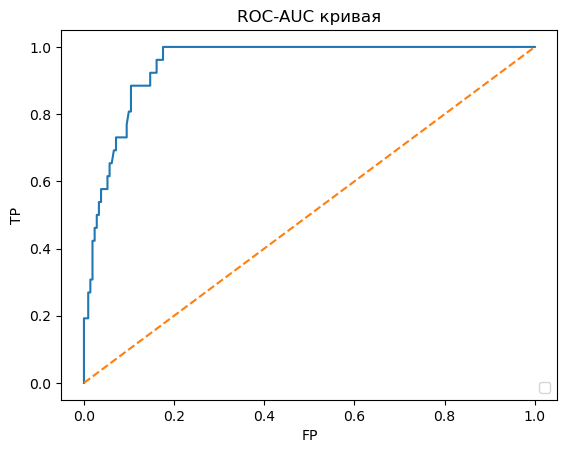

In [269]:
# 1) Get probabilities for the positive class
probabilities = best_lgbmc.predict_proba(X_test)[:, 1]   # LightGBM/XGBoost/RandomForest

# 2) Compute ROC points + AUC
FP, TP, thres = roc_curve(y_test, probabilities)
AUC_LINE = roc_auc_score(y_test, probabilities)
gini = 2*AUC_LINE - 1

# 3) Plot
plt.figure()
plt.plot(FP, TP)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC-AUC кривая')
plt.legend(loc='lower right')
plt.show()